# Correlation

This notebook is for Chapter 9 of [Think Stats - Probability and Statistics for Programmers](http://greenteapress.com/thinkstats/) by Allen B Downey.

Objective: Correlation, Linear Least Squares fitting, R-squared, etc.

In [1]:
from __future__ import division, print_function
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Standard Scores

__Correlation__ is a measure relating two different distributions.

Problem with this is that variables may not be expressed in same units. Two common solutions:

* Transform all values to __standard scores__, leads to __Pearson's coeffient__.
* Transform all values to __percentile ranks__, leads to __Spearman's coefficient__.

For standard scores, formula:

$$z_{i} = \frac {x_{i} - \mu}{\sigma}$$

If X is skewed or has outliers, so does Z, so its more robust to use percentile ranks. If R contains the percentile ranks of values in X, distribution of $R_{i}$s is uniform between 0 and 100, regardless of the distribution of X.

## Covariance

Measure of the tendency of two variables to vary together. Formula is:

$$Cov(X, Y) = \frac {1}{n} \sum (x_{i} - \mu_{X})(y_{i} - \mu_{Y})$$

where n is the length of the two series (they have to be of same length).

__Example 9.1:__ Write a function called Cov that takes two lists and computes their covariance. To test your function, compute the covariance of a list with itself and confirm that Cov(X, X) = Var(X).

In [2]:
def cov(xs, ys):
    assert(len(xs) == len(ys))
    mux = np.mean(xs)
    muy = np.mean(ys)
    return np.sum(np.multiply(xs - mux, ys - muy)) / len(xs)

dist_x = np.random.uniform(0, 100, 100)
dist_y = np.random.uniform(50, 150, 100)
print("cov(x, y): %.3f" % (cov(dist_x, dist_y)))
print("cov(x, x): %.3f, var(x): %.3f" % (cov(dist_x, dist_x), np.power(np.std(dist_x), 2)))

cov(x, y): -92.052
cov(x, x): 878.326, var(x): 878.326


## Correlation

Problem with Covariance is non-intuitiveness and different units, so not generally used. Better metric is __Pearson Correlation__, which is normalized by standard deviations:

$$\rho = \frac {1}{n} \sum \frac {(x_{i} - \mu_{X})}{\sigma_{X}} \frac {(y_{i} - \mu_{Y})}{\sigma_{Y}} = \frac {Cov(X, Y)}{\sigma_{X} \sigma_{Y}} $$

Value is between -1 and 1 both inclusive.

One important caveat is that Pearson's coefficient only measures __linear relationships__. If there is a non-linear relationship, $\rho$ understates the strength of the relationship.

__Exercise 9.2:__ Write a function called Corr that takes two lists and computes their correlation.

To test your function, compute the covariance of a list with itself and confirm that Corr(X, X) is 1.

In [3]:
def corr(xs, ys):
    std_x = np.std(xs)
    std_y = np.std(ys)
    return cov(xs, ys) / (std_x * std_y)

dist_x = np.random.uniform(0, 100, 100)
dist_y = np.random.uniform(50, 150, 100)
print("correlation(x, y): %.3f" % (corr(dist_x, dist_y)))
print("correlation(x, x): %.3f" % (corr(dist_x, dist_x)))

correlation(x, y): 0.130
correlation(x, x): 1.000


In [4]:
brfs_data = pd.read_fwf("CDBRFS08.ASC", 
                       names=["age", "weight2", "wtyrago", "sex", "htm3", "wtkg2"],
                       colspecs=[(100, 102), (119, 122), (127, 130), (142, 143), (1251, 1253),
                                 (1254, 1258)])
brfs_weight_and_heights = brfs_data[["weight2", "htm3"]].dropna()
weights = np.array(brfs_weight_and_heights["weight2"])
heights = np.array(brfs_weight_and_heights["htm3"])

print("pearson correlation (height vs weight): %.3f" % (corr(weights, heights)))

pearson correlation (height vs weight): 0.138


Text(0, 0.5, 'weights')

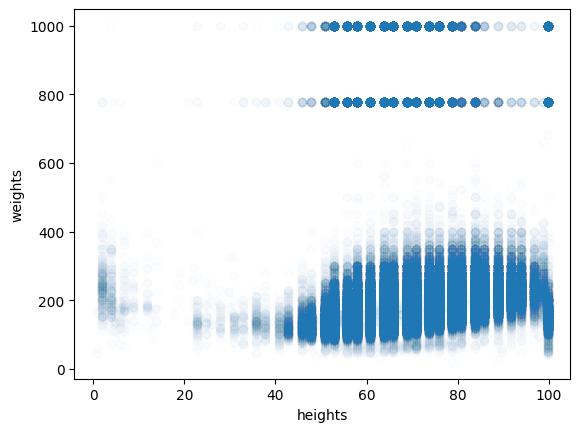

In [5]:
# alpha for transparency
jitter = 1.3
heights = heights + np.random.uniform(-jitter, jitter)
plt.scatter(heights, weights, alpha=0.01)
plt.xlabel("heights")
plt.ylabel("weights")

(40.0, 100.0)

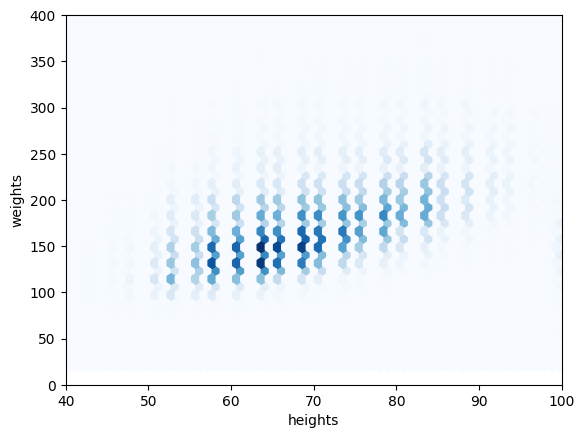

In [6]:
# another way to show correlation plots using hexbin
plt.hexbin(heights, weights, cmap=matplotlib.cm.Blues)
plt.xlabel("heights")
plt.ylabel("weights")
plt.ylim(0, 400)
plt.xlim(40, 100)

## Spearman's Rank Correlation

Spearman's coefficient mitigates the effect of skewness and outliers. We first compute ranks of each element and then the Pearson coefficient of the ranks.

Alternative to Spearman’s is to apply a transform that makes the data more nearly normal, then compute Pearson’s correlation for the transformed data. For example, if the data are approximately lognormal, you could take the log of each value and compute the correlation of the logs.

__Exercise 9.3:__ Write a function that takes a sequence and returns a list that contains the rank for each element. For example, if the sequence is {7, 1, 2, 5}, the result should be { 4, 1, 2, 3}.

In [7]:
def to_rank(xs):
    xs_ord = np.argsort(xs)
    return np.argsort(xs_ord) + 1

xs = np.array([7, 1, 2, 5])
print(to_rank(xs))

[4 1 2 3]


__Exercise 9.4 (a):__ Because the distribution of adult weight is lognormal, there are outliers that affect the correlation. Try plotting log(weight) versus height, and compute Pearson’s correlation for the transformed variable.

In [8]:
log_weights = np.log(weights)
pearson_logwgt_coeff = corr(log_weights, heights)
print("pearson correlation (height vs log(weight)): %.3f" % (pearson_logwgt_coeff))

pearson correlation (height vs log(weight)): 0.284


Text(0, 0.5, 'log(weights)')

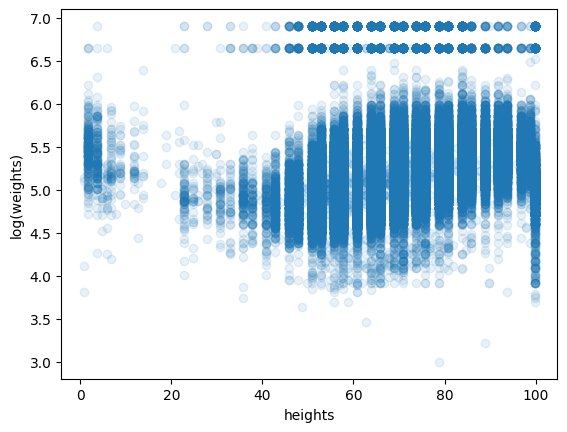

In [9]:
plt.scatter(heights, log_weights, alpha=0.1)
plt.xlabel("heights")
plt.ylabel("log(weights)")

__Exercise 9.4 (b):__ Write a function that takes two sequences (with the same length) and computes their Spearman rank coefficient.

In [10]:
weights_ranked = to_rank(weights)
heights_ranked = to_rank(heights)
spearman_coeff = corr(weights_ranked, heights_ranked)
print("spearman correlation (height vs weight): %.3f" % (spearman_coeff))

spearman correlation (height vs weight): 0.475


## Least-Squares Fit

Used to measure __slope__ of relationship. A __least squares fit__ is one that minimizes the mean squared error (MSE) between the fitted line and data.

Given two distributions X and Y with a suspected linear relationship $y_{i} = \alpha x_{i} + \beta$, there is usually some residual $\epsilon_{i}$ which can be written as:

$$\epsilon_{i} = (\alpha + \beta x_{i}) - y_{i}$$

We want to choose $\alpha$ and $\beta$ that minimizes the residual, ie:

$$min_{\alpha, \beta} = \sum \epsilon_{i}^{2}$$

Using least-squares, the estimated slope and intercept are:

$$\hat{\beta} = \frac {cov(X, Y)}{Var(X)} \space ; \space \hat{alpha} = \bar{y} - \hat{\beta} \bar{x}$$

__Exercise 9.5:__ Write a function named LeastSquares that takes X and Y and computes $\alpha$ and $\beta$.

In [11]:
def least_squares(xs, ys):
    x_bar = np.mean(xs)
    y_bar = np.mean(ys)
    beta = cov(xs, ys) / cov(xs, xs)
    alpha = y_bar - (beta * x_bar)
    return alpha, beta

alpha, beta = least_squares(weights, heights)
print("slope, intercept for heights vs weights: %.3f, %.3f" % (beta, alpha))

slope, intercept for heights vs weights: 0.010, 67.790


Text(0, 0.5, 'heights')

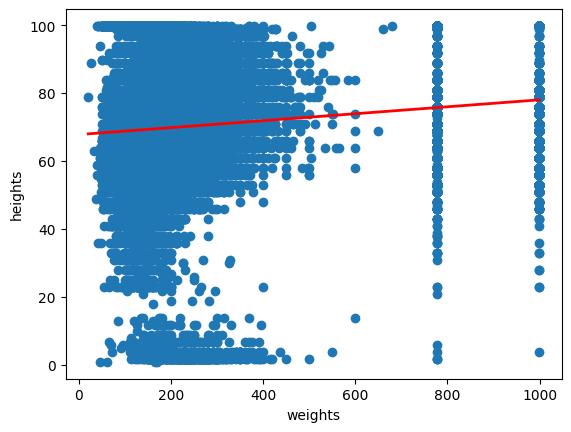

In [12]:
plt.scatter(weights, heights)
# draw line of best fit
weight_minmax = [np.min(weights), np.max(weights)]
height_minmax = [beta * w + alpha for w in weight_minmax]
plt.plot(weight_minmax, height_minmax, color="r", linewidth=2)
plt.xlabel("weights")
plt.ylabel("heights")

__Exercise 9.6:__ Using the data from the BRFSS again, compute the linear least squares fit for log(weight) versus height.

In [13]:
alpha, beta = least_squares(heights, np.log(weights))
print("slope, intercept for heights vs log(weights): %.3f, %.3f" % (beta, alpha))

slope, intercept for heights vs log(weights): 0.010, 4.472


Text(0, 0.5, 'heights')

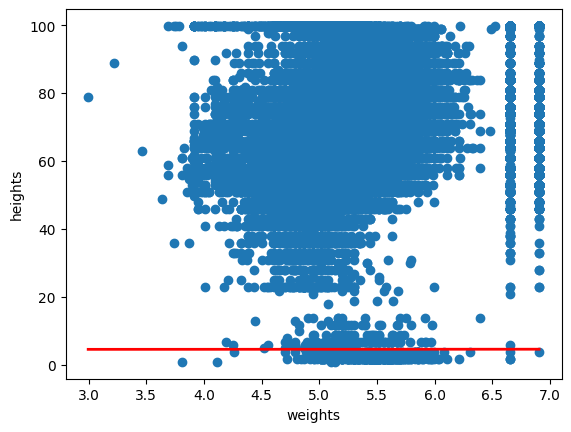

In [14]:
plt.scatter(np.log(weights), heights)
# draw line of best fit
weight_minmax = [np.min(np.log(weights)), np.max(np.log(weights))]
height_minmax = [beta * w + alpha for w in weight_minmax]
plt.plot(weight_minmax, height_minmax, color="r", linewidth=2)
plt.xlabel("weights")
plt.ylabel("heights")

## Goodness of fit

To measure the predictive power of a model, we compute the __coefficient of determination__, which represents the __variability explained by the model__.

$$R^{2} = 1 - \frac {Var(\epsilon)}{Var(Y)}$$

For linear models, the following relation holds:

$$R^{2} = \rho^{2}$$

__Exercise 9.8:__ The Wechsler Adult Intelligence Scale (WAIS) is meant to be a measure of intelligence; scores are calibrated so that the mean and standard deviation in the general population are 100 and 15. 

Suppose that you wanted to predict someone’s WAIS score based on their SAT scores. According to one study, there is a Pearson correlation of 0.72 between total SAT scores and WAIS scores.

If you applied your predictor to a large sample, what would you expect to be the mean squared error (MSE) of your predictions? (Hint: What is the MSE if you always guess 100?)

_From [here](https://www.algebra.com/algebra/homework/word/mixtures/Mixture_Word_Problems.faq.question.74649.html) we find that SAT mean and std are 1026 and 209 respectively. So assuming someone with 1600 SAT score, we need to find the equivalent WAIS score._

In [1]:
sat_x = 1600
sat_z = (sat_x - 1026) / 209
wais_z = 0.72 * sat_z
wais_y = 100 + wais_z * 15
print("WAIS score for someone with 2000 SAT score: %.3f" % (wais_y))

WAIS score for someone with 2000 SAT score: 129.661


__Exercise 9.9:__ Write a function named Residuals that takes X, Y, $\hat{\alpha}$ and $\hat{\beta}$ and returns a list of $\epsilon_{i}$. 

Write a function named CoefDetermination that takes the $\epsilon_{i}$ and Y and returns
$R^{2}$. To test your functions, confirm that $R^{2}$ = $\rho^{2}$.

In [17]:
def residual(xs, ys, alpha, beta):
    return alpha + (beta * xs) - ys

def r_squared(epsilons, ys):
    return 1 - (np.var(epsilons) / np.var(ys))

alpha, beta = least_squares(heights, weights)
epsilons = residual(heights, weights, alpha, beta)
print("R^2 for heights and weights: %.3f" % (r_squared(epsilons, weights)))
print("pearson coeff for height vs weight: %.3f" % (corr(heights, weights)))

R^2 for heights and weights: 0.019
pearson coeff for height vs weight: 0.138


## Correlation and Causation

Correlation does not imply causation, but we can test for causation using the following:

* __Time:__ If A comes before B, A can cause B but not the other way round.
* __Randomness:__ divide group into 2 randomly and compute means of almost any variable, you expect the difference to be small. If groups are nearly identical in all variables but one, you can eliminate spurious relationships.

These ideas are the motivation for the __randomized control trial__.

__Exercise 9.11:__ The NSFG data includes a variable named agepreg that records the age of the mother at the time of birth. Make a scatterplot of mother’s age and baby’s weight for each live birth. Can you see a relationship?

Compute a linear least-squares fit for these variables. What are the units of the estimated parameters $\alpha$ and $\beta$? How would you summarize these results in a sentence or two?

Compute the average age for mothers of first babies and the average age of other mothers. Based on the difference in ages between the groups, how much difference do you expect in the mean birth weights? What fraction of the actual difference in birth weights is explained by the difference in ages?

In [19]:
pregnancies = pd.read_fwf("2002FemPreg.dat", 
                         names=["caseid", "nbrnaliv", "babysex", "birthwgt_lb",
                               "birthwgt_oz", "prglength", "outcome", "birthord",
                               "agepreg", "finalwgt"],
                         colspecs=[(0, 12), (21, 22), (55, 56), (57, 58), (58, 60),
                                (274, 276), (276, 277), (278, 279), (283, 285), (422, 439)])
pregnancies.head()

,caseid,nbrnaliv,babysex,birthwgt_lb,birthwgt_oz,prglength,outcome,birthord,agepreg,finalwgt
0,1,1.0,1.0,8.0,13.0,39,1,1.0,33.0,6448.271112
1,1,1.0,2.0,7.0,14.0,39,1,2.0,39.0,6448.271112
2,2,3.0,1.0,9.0,2.0,39,1,1.0,14.0,12999.542264
3,2,1.0,2.0,7.0,0.0,39,1,2.0,17.0,12999.542264
4,2,1.0,2.0,6.0,3.0,39,1,3.0,18.0,12999.542264


In [20]:
live_births = pregnancies[pregnancies["outcome"] == 1]
live_births["totwgt"] = live_births["birthwgt_lb"] * 16 + live_births["birthwgt_oz"]
a_vs_b = live_births[["totwgt", "agepreg"]].dropna()
mother_age = np.array(a_vs_b["agepreg"])
birth_wgt = np.array(a_vs_b["totwgt"])

C:\Users\diptiwar\AppData\Local\Temp\ipykernel_12040\1116247420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  live_births["totwgt"] = live_births["birthwgt_lb"] * 16 + live_births["birthwgt_oz"]


In [21]:
pearson_coeff = corr(mother_age, birth_wgt)
print("pearson coeff for mother age vs baby weight: %.3f" % (pearson_coeff))

pearson coeff for mother age vs baby weight: 0.048


In [22]:
alpha, beta = least_squares(mother_age, birth_wgt)
print("alpha: %.3f, beta: %.3f" % (alpha, beta))

alpha: 108.110, beta: 0.225


Text(0, 0.5, 'baby weight')

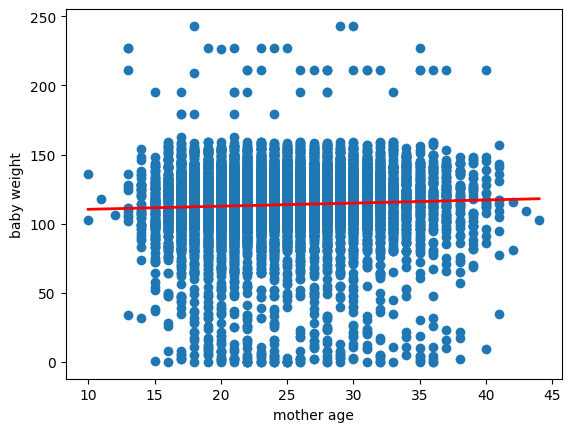

In [23]:
plt.scatter(mother_age, birth_wgt)
x_minmax = [np.min(mother_age), np.max(mother_age)]
y_minmax = [beta * x + alpha for x in x_minmax]
plt.plot(x_minmax, y_minmax, color="r", linewidth=2)
plt.xlabel("mother age")
plt.ylabel("baby weight")

In [24]:
first_babies = live_births[live_births["birthord"] == 1][["totwgt", "agepreg"]].dropna()
other_babies = live_births[live_births["birthord"] != 1][["totwgt", "agepreg"]].dropna()
first_ages = np.array(first_babies["agepreg"])
other_ages = np.array(other_babies["agepreg"])
first_weights = np.array(first_babies["totwgt"])
other_weights = np.array(other_babies["totwgt"])

mean_first_age = np.mean(first_ages)
mean_other_age = np.mean(other_ages)
print("average age of first baby mothers: %.3f, other mothers: %.3f" % 
      (mean_first_age, mean_other_age))
diff_age = mean_first_age - mean_other_age

expected_diff_wgt = beta * diff_age

mean_first_wgt = np.mean(first_weights)
mean_other_wgt = np.mean(other_weights)
diff_wgt = mean_first_wgt - mean_other_wgt

print("diff in birth weights, expected: %.3f, actual: %.3f" % (expected_diff_wgt, diff_wgt))

r_squared = math.pow(pearson_coeff, 2)
print("fraction of birth weight diff explained by mother age diff: %.3f" % (r_squared))

average age of first baby mothers: 22.628, other mothers: 26.203
diff in birth weights, expected: -0.806, actual: -1.842
fraction of birth weight diff explained by mother age diff: 0.002
